# Test predizione COVID con BackFeatureMapper

In [1]:
import pickle
import numpy as np
import pandas as pd
from aidam.miscellanea_utils import var_column_mapper
from matplotlib import pyplot as plt
from aidam.BackFeatureMapper import BackFeatureBrewer, BackFeatureMapper
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
data_file='stored_data.pkl'

## Data import e preprocessing

In [3]:
# lettura dati
infile=open(data_file,'rb')
trend=pickle.load(infile)
regioni=pickle.load(infile)
giorni=pickle.load(infile)
giorno_settimana=pickle.load(infile)
infile.close()

### Creazione della matrice di input e target

In [4]:
# selezione regione oggetto dello studio
regione='Italia'

# costruzione matrici di input e target
input_vars=['totale_ospedalizzati']
target_var='terapia_intensiva'
input_list=[]
input_list=[trend[v][regione] for v in input_vars]
input_data=np.array(input_list).T
target_data=trend[target_var][regione]


scaler=MinMaxScaler()
scaler.fit(input_data)
input_data=scaler.transform(input_data)


### Divisione training test

In [5]:
num_samples=len(giorni)

num_tr_samples=int(num_samples*0.7)
num_tr_samples

input_tr=input_data[0:num_tr_samples,:]
input_ts=input_data[num_tr_samples:,:]

target_tr=target_data[0:num_tr_samples]
target_ts=target_data[num_tr_samples:]


print('RAW DATA')
print('%d Training samples   %d Validation samples'%(len(target_tr),len(target_ts)))

RAW DATA
256 Training samples   111 Validation samples


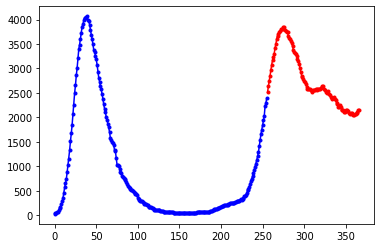

In [6]:
plt.plot(list(range(0,num_tr_samples)),target_tr,'b.-')
plt.plot(list(range(num_tr_samples,num_samples)),target_ts,'r.-')

## Training e test modello

### Preparazione e applicazione del mapper

In [7]:
eso_backsight=5
endo_backsight=5
foresight=14

def difference(x):
    return x[-1]-x[0]


eso=[BackFeatureMapper(column=0,backsight=eso_backsight,mapfun=np.mean),
     BackFeatureMapper(column=0,backsight=eso_backsight,mapfun=difference)
    ]
endo=[BackFeatureMapper(column=0,backsight=endo_backsight,mapfun=np.mean)]


the_brewer=BackFeatureBrewer(esomappers=eso, endomappers=endo)
#the_brewer=BackFeatureBrewer(esomappers=eso)

In [8]:
indici_tr,tr_myin,tr_mytar=the_brewer.transform(input_tr,
                                      target_tr,
                                      map_target=True,
                                      foresight=foresight)

indici_ts,ts_myin=the_brewer.transform(input_ts,target_ts,
                                      map_target=False,
                                      foresight=foresight)

print('FEATURES DATA')
print('%d Training samples   %d Validation samples'%(tr_myin.shape[0],ts_myin.shape[0]))

whole_cut=input_tr.shape[0]-tr_myin.shape[0]
head_cut=whole_cut-foresight

print('Whole cut: %d'%whole_cut)
print('Head cut: %d'%head_cut)

FEATURES DATA
237 Training samples   106 Validation samples
Whole cut: 19
Head cut: 5


### Training e test modello

In [9]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=1)

model.fit(tr_myin,tr_mytar)

tr_pred=model.predict(tr_myin)
ts_pred=model.predict(ts_myin)

print(tr_pred.shape)
print(ts_pred.shape)

(237,)
(106,)


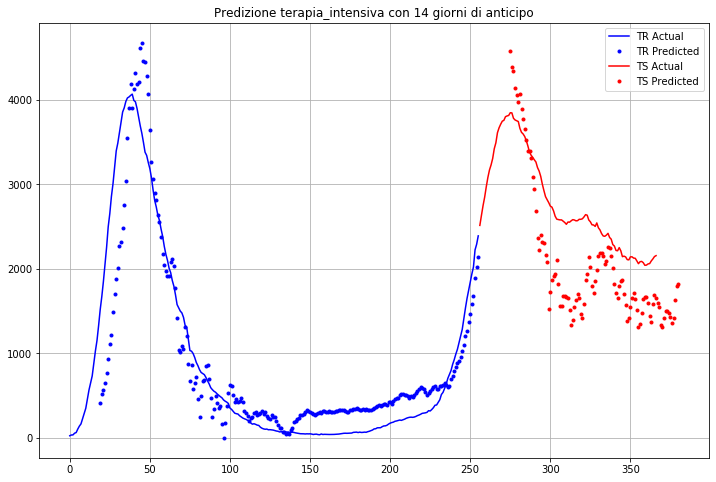

In [10]:
#print('Errore TR: %5.2f   Errore TS: %5.2f'%(errore_tr,errore_ts))

plt.figure(figsize=(12,8))
plt.plot(range(len(target_tr)),target_tr,'b',label='TR Actual')
plt.plot(range(whole_cut,len(target_tr)),tr_pred,'b.',label='TR Predicted')
plt.plot(range(len(target_tr),num_samples),target_ts,'r',label='TS Actual')
plt.plot(range(len(target_tr)+whole_cut,len(target_tr)+len(ts_pred)+whole_cut),ts_pred,'r.',label='TS Predicted')
plt.title('Predizione %s con %d giorni di anticipo'%(target_var,foresight))
plt.legend()
plt.grid()
plt.show()

In [11]:
giorni

array(['2020-02-24T18:00:00', '2020-02-25T18:00:00',
       '2020-02-26T18:00:00', '2020-02-27T18:00:00',
       '2020-02-28T18:00:00', '2020-02-29T17:00:00',
       '2020-03-01T17:00:00', '2020-03-02T18:00:00',
       '2020-03-03T18:00:00', '2020-03-04T17:00:00',
       '2020-03-05T17:00:00', '2020-03-06T17:00:00',
       '2020-03-07T18:00:00', '2020-03-08T18:00:00',
       '2020-03-09T18:00:00', '2020-03-10T18:00:00',
       '2020-03-11T17:00:00', '2020-03-12T17:00:00',
       '2020-03-13T17:00:00', '2020-03-14T17:00:00',
       '2020-03-15T17:00:00', '2020-03-16T17:00:00',
       '2020-03-17T17:00:00', '2020-03-18T17:00:00',
       '2020-03-19T17:00:00', '2020-03-20T17:00:00',
       '2020-03-21T17:00:00', '2020-03-22T17:00:00',
       '2020-03-23T17:00:00', '2020-03-24T17:00:00',
       '2020-03-25T17:00:00', '2020-03-26T17:00:00',
       '2020-03-27T17:00:00', '2020-03-28T17:00:00',
       '2020-03-29T17:00:00', '2020-03-30T17:00:00',
       '2020-03-31T17:00:00', '2020-04-01T17:0

In [12]:
ts_pred

array([ 582.25374864,  615.35122501,  621.16247734,  626.46248332,
        648.00032861,  632.37795996,  610.72893715,  618.06418472,
        697.3004138 ,  729.7703552 ,  782.34213977,  826.05975616,
        872.43916264,  896.80106775,  937.00782061, 1007.15624355,
       1076.55293627, 1175.4206705 , 1238.39074292, 1338.27743435,
       1424.31000182, 1537.29214889, 1629.67178273, 1832.98464094,
       1951.58508736, 2063.54302807, 2234.73919048, 2364.19007145,
       2399.43209202, 2597.34348553, 2790.71756677, 2939.19286282,
       3104.03467943, 3288.09285756, 3362.46872226, 3417.11754818,
       3444.5620331 , 3652.42950648, 3708.93730163, 3845.43872607,
       3864.85943744, 4012.02729958, 4082.91775435, 4242.29145462,
       4281.03208033, 4374.35204195, 4201.6201664 , 4153.21766225,
       3958.44213368, 3890.1419868 , 3812.78516099, 3906.92749775,
       3738.87369803, 3629.52638942, 3528.83263588, 3400.01464132,
       3283.14433366, 3282.07005884, 3204.26014176, 2999.11912